# Training a DeepSpeech LSTM Model using the LibriSpeech Data 
At the end of Chapter 10 in the book it is suggested try and build an automatic speech recognition system using the LibriVox corpus and long short term memory (LSTM) models just learned in the Recurrent Neural Network (RNN) chapter. This particular excercise turned out to be quite difficult mostly from the perspective again of simply gathering and formatting the data, combined with the work to understand the LSTM was doing. As it turns out, in doing this assignment I taught myself about MFCCs (mel frequency cepstral coefficient) which are simply what is going on in the  Bregman Toolkit example earlier in the book. It's a process to convert audio into *num_cepstrals* coefficients using an FFT, and to use those coeffiicents as amplitudes and convert from the frequency into the time domain. LSTMs need time series data and a number of audio files converted using MFCCs into frequency amplitudes corresponding to utterances that you have transcript data for and you are in business!

The other major lesson was finding [RNN-Tutorial](https://github.com/mrubash1/RNN-Tutoria) an existing GitHub repository that implements a simplified version of the [deepspeech model](https://github.com/mozilla/DeepSpeech) from Mozilla which is a TensorFlow implementation of the Baidu model from the [seminal paper](https://arxiv.org/abs/1412.5567) in 2014.

I had to figure out along the way how to tweak hyperparameters including epochs, batch size, and training data. But overall this is a great architecture and example of how to use validation/dev sets during training for looking at validation loss compared to train loss and then overall to measure test accuracy.

### Data Preprocessing Steps:
   1. Grab all text files which start out as the full speech from all subsequent \*.flac files
   2. Each line in the text file contains:
       ```
       filename(without .txt at end) the speech present in the file, e.g., words separated by spaces
       filename N ... words ....
       ```
   3. Then convert all \*.flac files to \*.wav files, using `flac2wav`
   4. Remove all the flac files and remove the \*.trans.txt files
   5. Run this code in the notebook below to generate the associated \*.txt file to go along with each \*.wav file.
   6. Move all the \*.wav and \*.txt files into a single folder, e.g., `LibriSpeech/train-clean-all` 
   7. Repeat for test and dev
   
Once complete, you have a dataset to run through [RNN-Tutorial](https://github.com/mrubash1/RNN-Tutorial.git)

### References
   1. [PyDub](https://github.com/jiaaro/pydub) - PyDub library
   2. [A short reminder of how CTC works](https://towardsdatascience.com/beam-search-decoding-in-ctc-trained-neural-networks-5a889a3d85a7)
   3. [OpenSLR - LibriSpeech corpus](http://www.openslr.org/12)
   4. [Hamsa's Deep Speech notebook](https://github.com/cosmoshsv/Deep-Speech/blob/master/DeepSpeech_RNN_Training.ipynb)
   5. [LSTM's by example using TensorFlow](https://towardsdatascience.com/lstm-by-example-using-tensorflow-feb0c1968537) 
   6. [How to read an audio file using TensorFlow APIs](https://github.com/tensorflow/tensorflow/issues/28237)
   7. [Audio spectrograms in TensorFlow](https://mauri870.github.io/blog/posts/audio-spectrograms-in-tensorflow/)
   8. [Reading audio files using TensorFlow](https://github.com/tensorflow/tensorflow/issues/32382)
   9. [TensorFlow's decode_wav API](https://www.tensorflow.org/api_docs/python/tf/audio/decode_wav)
   10. [Speech Recognition](https://towardsdatascience.com/speech-recognition-analysis-f03ff9ce78e9)
   11. [Using TensorFlow's audio ops](https://stackoverflow.com/questions/48660391/using-tensorflow-contrib-framework-python-ops-audio-ops-audio-spectrogram-to-gen)
   12. [LSTM by Example - Towards Data Science](https://towardsdatascience.com/lstm-by-example-using-tensorflow-feb0c1968537)
   13. [Training your Own Model -  DeepSpeech](https://deepspeech.readthedocs.io/en/v0.7.3/TRAINING.html)
   14. [Understanding LSTMs](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
   15. [Implementing  LSTMs](https://apaszke.github.io/lstm-explained.html)
   16. [Mel Frequency Cepstral Coefficient](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)
   17. [TensorFlow - Extract Every Other Element](https://stackoverflow.com/questions/46721407/tensorflow-extract-every-other-element)
   18. [Plotting MFCCs in TensorFlow](https://stackoverflow.com/questions/47056432/is-it-possible-to-get-exactly-the-same-results-from-tensorflow-mfcc-and-librosa)
   19. [MFCCs in TensorFlow](https://kite.com/python/docs/tensorflow.contrib.slim.rev_block_lib.contrib_framework_ops.audio_ops.mfcc)
   20. [How to train Baidu's Deep Speech Model with Kur](https://blog.deepgram.com/how-to-train-baidus-deepspeech-model-with-kur/)
   21. [Silicon Valley Data Science SVDS - RNN Tutorial](https://www.svds.com/tensorflow-rnn-tutorial/)
   22. [Streaming RNNs with TensorFlow](https://hacks.mozilla.org/2018/09/speech-recognition-deepspeech/)
   

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.audio import decode_wav
from tensorflow.contrib.framework.python.ops import audio_ops
from tensorflow.python.ops import ctc_ops
from tensorflow.data.experimental import AUTOTUNE 
from pydub import AudioSegment
import scipy.io.wavfile as wav
from python_speech_features import mfcc
from tqdm import tqdm_notebook as tqdm
import shutil
import urllib.request
import tarfile
from basic_units import cm, inch
import os
import glob
import sys
import unicodedata
import codecs
import re

In [2]:
# Constants
SPACE_TOKEN = '<space>'
SPACE_INDEX = 0
FIRST_INDEX = ord('a') - 1  # 0 is reserved to space

In [3]:
train_url = "http://www.openslr.org/resources/12/train-clean-100.tar.gz"
dev_url = "http://www.openslr.org/resources/12/dev-clean.tar.gz"
test_url = "http://www.openslr.org/resources/12/test-clean.tar.gz"

In [4]:
speech_data_path = "LibriSpeech"
train_path = speech_data_path + "/train-clean-100"
dev_path = speech_data_path + "/dev-clean"
test_path = speech_data_path + "/test-clean"

all_train_path = train_path + "-all"
all_dev_path = dev_path + "-all"
all_test_path = test_path + "-all"

In [5]:
train_transcripts = [file for file in glob.glob(all_train_path + "/*.txt")]
dev_transcripts = [file for file in glob.glob(all_dev_path + "/*.txt")]
test_transcripts = [file for file in glob.glob(all_test_path + "/*.txt")]

In [6]:
train_audio_wav = [file for file in glob.glob(all_train_path + "/*.wav")]
dev_audio_wav = [file for file in glob.glob(all_dev_path + "/*.wav")]
test_audio_wav = [file for file in glob.glob(all_test_path + "/*.wav")]

In [7]:
def download_and_extract_tar(url):
    print("Downloading and extracting %s " % (url))
    tar_stream = urllib.request.urlopen(url)
    tar_file = tarfile.open(fileobj=tar_stream, mode="r|gz")
    tar_file.extractall()

In [8]:
def flac2wav(filepath):
    base_file_path = os.path.dirname(filepath)
    filename = os.path.basename(filepath)
    filename_no_ext = os.path.splitext(filename)[0]
    audio = AudioSegment.from_file(filepath, "flac")
    wav_file_path = base_file_path + '/' + filename_no_ext +'.wav'
    #print('Converting FLAC audio file %s to WAV audio file %s' % (filepath, wav_file_path))
    audio.export(wav_file_path, format="wav")

In [9]:
def remove_files_with_ext(directory, ext):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(ext):
                path_to_file = os.path.join(root, file)
                print("Removing file %s " % (path_to_file))                
                os.remove(path_to_file)   

In [10]:
def create_per_file_transcripts(file):
    file_toks = file.split('.')
    base_file_path = os.path.dirname(file)
    with open(file, 'r') as fd:
        lines = fd.readlines()
        for line in lines:
            toks = line.split(' ')
            wav_file_name = base_file_path + '/' + toks[0] + '.txt'
            #print('Writing %s ' % wav_file_name)
            with open(wav_file_name, 'w') as of:
                trans = " ".join([t.lower() for t in toks[1:]])
                of.write(trans)
                of.write('\n')

In [11]:
def convert_flac_to_wav(train_path, dev_path, test_path):
    train_flac = [file for file in glob.glob(train_path + "/*/*/*.flac")]
    dev_flac = [file for file in glob.glob(dev_path + "/*/*/*.flac")]
    test_flac = [file for file in glob.glob(test_path + "/*/*/*.flac")]
    
    print("Converting %d train %d dev and %d test flac files into wav files" 
          % (len(train_flac), len(dev_flac), len(test_flac)))    
    
    print("Processing train")
    for f in tqdm(train_flac):
        flac2wav(f)
    
    print("Processing dev")
    for f in tqdm(dev_flac):
        flac2wav(f)
        
    print("Processing test")
    for f in tqdm(test_flac):
        flac2wav(f)

In [12]:
def gen_transcripts(train_path, dev_path, test_path):
    train_transcripts = [file for file in glob.glob(train_path + "/*/*/*.txt")]
    dev_transcripts = [file for file in glob.glob(dev_path + "/*/*/*.txt")]
    test_transcripts = [file for file in glob.glob(test_path + "/*/*/*.txt")]
    
    print("Converting %d train %d dev and %d test aggregate transcripts into individual transcripts" 
          % (len(train_transcripts), len(dev_transcripts), len(test_transcripts)))
    
    print("Processing train")
    for f in tqdm(train_transcripts):
        create_per_file_transcripts(f)
    
    print("Processing dev")
    for f in tqdm(dev_transcripts):
        create_per_file_transcripts(f)
        
    print("Processing test")
    for f in tqdm(test_transcripts):
        create_per_file_transcripts(f) 

In [13]:
def convert_flac_and_gen_transcripts(train_path, dev_path, test_path):
    convert_flac_to_wav(train_path, dev_path, test_path)
    gen_transcripts(train_path, dev_path, test_path)

In [14]:
def move_files(from_path, to_path):
    if not os.path.exists(to_path):
        print("Creating dir %s" % (to_path))
        os.makedirs(to_path)
    for root, _, files in os.walk(from_path):
        for file in files:
            path_to_file = os.path.join(root, file)
            base_file_path = os.path.dirname(file)
            to_path_file = to_path + '/' + file
            print("Moving file from %s to %s " % (path_to_file, to_path_file))
            shutil.move(path_to_file, to_path_file)

In [15]:
def BiRNN_model(batch_x, seq_length, n_input, n_context):
    dropout = [0.05, 0.05, 0.05, 0.0, 0.0, 0.05]
    relu_clip = 20

    b1_stddev = 0.046875
    h1_stddev = 0.046875
    b2_stddev = 0.046875
    h2_stddev = 0.046875
    b3_stddev = 0.046875
    h3_stddev = 0.046875
    b5_stddev = 0.046875
    h5_stddev = 0.046875
    b6_stddev = 0.046875
    h6_stddev = 0.046875

    n_hidden_1 = 1024
    n_hidden_2 = 1024
    n_hidden_5 = 1024
    n_cell_dim = 1024

    n_hidden_3 = 2048
    n_hidden_6 = 29    
    n_character = 29

    # Input shape: [batch_size, n_steps, n_input + 2*n_input*n_context]
    batch_x_shape = tf.shape(batch_x)

    # Reshaping `batch_x` to a tensor with shape `[n_steps*batch_size, n_input + 2*n_input*n_context]`.
    # This is done to prepare the batch for input into the first layer which expects a tensor of rank `2`.

    # Permute n_steps and batch_size
    batch_x = tf.transpose(batch_x, [1, 0, 2])
    # Reshape to prepare input for first layer
    batch_x = tf.reshape(batch_x,
                         [-1, n_input + 2 * n_input * n_context])  # (n_steps*batch_size, n_input + 2*n_input*n_context)

    # The next three blocks will pass `batch_x` through three hidden layers with
    # clipped RELU activation and dropout.

    # 1st layer
    with tf.name_scope('fc1'):
        b1 = tf.get_variable(name='b1', shape=[n_hidden_1], initializer=tf.random_normal_initializer(stddev=b1_stddev))
        h1 = tf.get_variable(name='h1', shape=[n_input + 2 * n_input * n_context, n_hidden_1],
                             initializer=tf.random_normal_initializer(stddev=h1_stddev))
        layer_1 = tf.minimum(tf.nn.relu(tf.add(tf.matmul(batch_x, h1), b1)), relu_clip)
        layer_1 = tf.nn.dropout(layer_1, (1.0 - dropout[0]))

        tf.summary.histogram("weights", h1)
        tf.summary.histogram("biases", b1)
        tf.summary.histogram("activations", layer_1)

    # 2nd layer
    with tf.name_scope('fc2'):
        b2 = tf.get_variable(name='b2', shape=[n_hidden_2], initializer=tf.random_normal_initializer(stddev=b2_stddev))
        h2 = tf.get_variable(name='h2', shape=[n_hidden_1, n_hidden_2], initializer=tf.random_normal_initializer(stddev=h2_stddev))
        layer_2 = tf.minimum(tf.nn.relu(tf.add(tf.matmul(layer_1, h2), b2)), relu_clip)
        layer_2 = tf.nn.dropout(layer_2, (1.0 - dropout[1]))

        tf.summary.histogram("weights", h2)
        tf.summary.histogram("biases", b2)
        tf.summary.histogram("activations", layer_2)

    # 3rd layer
    with tf.name_scope('fc3'):
        b3 = tf.get_variable(name='b3', shape=[n_hidden_3], initializer=tf.random_normal_initializer(stddev=b3_stddev))
        h3 = tf.get_variable(name='h3', shape=[n_hidden_2, n_hidden_3], initializer=tf.random_normal_initializer(stddev=h3_stddev))
        layer_3 = tf.minimum(tf.nn.relu(tf.add(tf.matmul(layer_2, h3), b3)), relu_clip)
        layer_3 = tf.nn.dropout(layer_3, (1.0 - dropout[2]))

        tf.summary.histogram("weights", h3)
        tf.summary.histogram("biases", b3)
        tf.summary.histogram("activations", layer_3)

    # Create the forward and backward LSTM units. Inputs have length `n_cell_dim`.
    # LSTM forget gate bias initialized at `1.0` (default), meaning less forgetting
    # at the beginning of training (remembers more previous info)
    with tf.name_scope('lstm'):
        # Forward direction cell:
        lstm_fw_cell = tf.contrib.rnn.BasicLSTMCell(n_cell_dim, forget_bias=1.0, state_is_tuple=True)
        lstm_fw_cell = tf.contrib.rnn.DropoutWrapper(lstm_fw_cell,
                                                     input_keep_prob=1.0 - dropout[3],
                                                     output_keep_prob=1.0 - dropout[3],
                                                     # seed=random_seed,
                                                     )
        # Backward direction cell:
        lstm_bw_cell = tf.contrib.rnn.BasicLSTMCell(n_cell_dim, forget_bias=1.0, state_is_tuple=True)
        lstm_bw_cell = tf.contrib.rnn.DropoutWrapper(lstm_bw_cell,
                                                     input_keep_prob=1.0 - dropout[4],
                                                     output_keep_prob=1.0 - dropout[4],
                                                     # seed=random_seed,
                                                     )

        # `layer_3` is now reshaped into `[n_steps, batch_size, 2*n_cell_dim]`,
        # as the LSTM BRNN expects its input to be of shape `[max_time, batch_size, input_size]`.
        layer_3 = tf.reshape(layer_3, [-1, batch_x_shape[0], n_hidden_3])

        # Now we feed `layer_3` into the LSTM BRNN cell and obtain the LSTM BRNN output.
        outputs, output_states = tf.nn.bidirectional_dynamic_rnn(cell_fw=lstm_fw_cell,
                                                                 cell_bw=lstm_bw_cell,
                                                                 inputs=layer_3,
                                                                 dtype=tf.float32,
                                                                 time_major=True,
                                                                 sequence_length=seq_length)

        tf.summary.histogram("activations", outputs)

        # Reshape outputs from two tensors each of shape [n_steps, batch_size, n_cell_dim]
        # to a single tensor of shape [n_steps*batch_size, 2*n_cell_dim]
        outputs = tf.concat(outputs, 2)
        outputs = tf.reshape(outputs, [-1, 2 * n_cell_dim])

    with tf.name_scope('fc5'):
        # Now we feed `outputs` to the fifth hidden layer with clipped RELU activation and dropout
        b5 = tf.get_variable(name='b5', shape=[n_hidden_5], initializer=tf.random_normal_initializer(stddev=b5_stddev))
        h5 = tf.get_variable(name='h5', shape=[(2 * n_cell_dim), n_hidden_5], initializer=tf.random_normal_initializer(stddev=h5_stddev))
        layer_5 = tf.minimum(tf.nn.relu(tf.add(tf.matmul(outputs, h5), b5)), relu_clip)
        layer_5 = tf.nn.dropout(layer_5, (1.0 - dropout[5]))

        tf.summary.histogram("weights", h5)
        tf.summary.histogram("biases", b5)
        tf.summary.histogram("activations", layer_5)

    with tf.name_scope('fc6'):
        # Now we apply the weight matrix `h6` and bias `b6` to the output of `layer_5`
        # creating `n_classes` dimensional vectors, the logits.
        b6 = tf.get_variable(name='b6', shape=[n_hidden_6], initializer=tf.random_normal_initializer(stddev=b6_stddev))
        h6 = tf.get_variable(name='h6', shape=[n_hidden_5, n_hidden_6], initializer=tf.random_normal_initializer(stddev=h6_stddev))
        layer_6 = tf.add(tf.matmul(layer_5, h6), b6)

        tf.summary.histogram("weights", h6)
        tf.summary.histogram("biases", b6)
        tf.summary.histogram("activations", layer_6)

    # Finally we reshape layer_6 from a tensor of shape [n_steps*batch_size, n_hidden_6]
    # to the slightly more useful shape [n_steps, batch_size, n_hidden_6].
    # Note, that this differs from the input in that it is time-major.
    layer_6 = tf.reshape(layer_6, [-1, batch_x_shape[0], n_hidden_6])

    summary_op = tf.summary.merge_all()

    # Output shape: [n_steps, batch_size, n_hidden_6]
    return layer_6, summary_op

In [16]:
def process_audio(audio_filename):
    # Load wav files
    fs, audio = wav.read(audio_filename)

    # Get mfcc coefficients
    orig_inputs = mfcc(audio, samplerate=fs, numcep=numcep)

    # We only keep every second feature (BiRNN stride = 2)
    orig_inputs = orig_inputs[::2]

    # For each time slice of the training set, we need to copy the context this makes
    # the numcep dimensions vector into a numcep + 2*numcep*numcontext dimensions
    # because of:
    #  - numcep dimensions for the current mfcc feature set
    #  - numcontext*numcep dimensions for each of the past and future (x2) mfcc feature set
    # => so numcep + 2*numcontext*numcep
    train_inputs = np.array([], np.float32)
    train_inputs.resize((orig_inputs.shape[0], numcep + 2 * numcep * numcontext))

    # Prepare pre-fix post fix context
    empty_mfcc = np.array([])
    empty_mfcc.resize((numcep))

    # Prepare train_inputs with past and future contexts
    time_slices = range(train_inputs.shape[0])
    context_past_min = time_slices[0] + numcontext
    context_future_max = time_slices[-1] - numcontext
    for time_slice in time_slices:
        # Reminder: array[start:stop:step]
        # slices from indice |start| up to |stop| (not included), every |step|

        # Add empty context data of the correct size to the start and end
        # of the MFCC feature matrix

        # Pick up to numcontext time slices in the past, and complete with empty
        # mfcc features
        need_empty_past = max(0, (context_past_min - time_slice))
        empty_source_past = list(empty_mfcc for empty_slots in range(need_empty_past))
        data_source_past = orig_inputs[max(0, time_slice - numcontext):time_slice]
        assert(len(empty_source_past) + len(data_source_past) == numcontext)

        # Pick up to numcontext time slices in the future, and complete with empty
        # mfcc features
        need_empty_future = max(0, (time_slice - context_future_max))
        empty_source_future = list(empty_mfcc for empty_slots in range(need_empty_future))
        data_source_future = orig_inputs[time_slice + 1:time_slice + numcontext + 1]
        assert(len(empty_source_future) + len(data_source_future) == numcontext)

        if need_empty_past:
            past = np.concatenate((empty_source_past, data_source_past))
        else:
            past = data_source_past

        if need_empty_future:
            future = np.concatenate((data_source_future, empty_source_future))
        else:
            future = data_source_future

        past = np.reshape(past, numcontext * numcep)
        now = orig_inputs[time_slice]
        future = np.reshape(future, numcontext * numcep)

        train_inputs[time_slice] = np.concatenate((past, now, future))
        assert(len(train_inputs[time_slice]) == numcep + 2 * numcep * numcontext)

    # Scale/standardize the inputs
    # This can be done more efficiently in the TensorFlow graph
    train_inputs = (train_inputs - np.mean(train_inputs)) / np.std(train_inputs)
    return train_inputs

In [17]:
def normalize_txt_file(txt_file, remove_apostrophe=True):
    """
    Given a path to a text file, return contents with unsupported characters removed.
    """
    with codecs.open(txt_file, encoding="utf-8") as open_txt_file:
        return normalize_text(open_txt_file.read(), remove_apostrophe=remove_apostrophe)

In [18]:
def normalize_text(original, remove_apostrophe=True):
    """
    Given a Python string ``original``, remove unsupported characters.
    The only supported characters are letters and apostrophes.
    """
    # convert any unicode characters to ASCII equivalent
    # then ignore anything else and decode to a string
    result = unicodedata.normalize("NFKD", original).encode("ascii", "ignore").decode()
    if remove_apostrophe:
        # remove apostrophes to keep contractions together
        result = result.replace("'", "")
    # return lowercase alphabetic characters and apostrophes (if still present)
    return re.sub("[^a-zA-Z']+", ' ', result).strip().lower()

In [19]:
def text_to_char_array(original):
    """
    Given a Python string ``original``, map characters
    to integers and return a numpy array representing the processed string.
    This function has been modified from Mozilla DeepSpeech:
    https://github.com/mozilla/DeepSpeech/blob/master/util/text.py
    # This Source Code Form is subject to the terms of the Mozilla Public
    # License, v. 2.0. If a copy of the MPL was not distributed with this
    # file, You can obtain one at http://mozilla.org/MPL/2.0/.
    """

    # Create list of sentence's words w/spaces replaced by ''
    result = original.replace(' ', '  ')
    result = result.split(' ')

    # Tokenize words into letters adding in SPACE_TOKEN where required
    result = np.hstack([SPACE_TOKEN if xt == '' else list(xt) for xt in result])

    # Return characters mapped into indicies
    return np.asarray([SPACE_INDEX if xt == SPACE_TOKEN else ord(xt) - FIRST_INDEX for xt in result])

In [20]:
def sparse_tuple_from(sequences, dtype=np.int32):
    """
    Create a sparse representention of ``sequences``.
    Args:
        sequences: a list of lists of type dtype where each element is a sequence
    Returns:
        A tuple with (indices, values, shape)
    This function has been modified from Mozilla DeepSpeech:
    https://github.com/mozilla/DeepSpeech/blob/master/util/text.py
    # This Source Code Form is subject to the terms of the Mozilla Public
    # License, v. 2.0. If a copy of the MPL was not distributed with this
    # file, You can obtain one at http://mozilla.org/MPL/2.0/.
    """

    indices = []
    values = []

    for n, seq in enumerate(sequences):
        indices.extend(zip([n] * len(seq), range(len(seq))))
        values.extend(seq)

    indices = np.asarray(indices, dtype=np.int64)
    values = np.asarray(values, dtype=dtype)
    shape = np.asarray([len(sequences), indices.max(0)[1] + 1], dtype=np.int64)

    # return tf.SparseTensor(indices=indices, values=values, shape=shape)
    return indices, values, shape

In [21]:
def pad_sequences(sequences, maxlen=None, dtype=np.float32,
                  padding='post', truncating='post', value=0.):

    '''
    # From TensorLayer:
    # http://tensorlayer.readthedocs.io/en/latest/_modules/tensorlayer/prepro.html
    Pads each sequence to the same length of the longest sequence.
        If maxlen is provided, any sequence longer than maxlen is truncated to
        maxlen. Truncation happens off either the beginning or the end
        (default) of the sequence. Supports post-padding (default) and
        pre-padding.
        Args:
            sequences: list of lists where each element is a sequence
            maxlen: int, maximum length
            dtype: type to cast the resulting sequence.
            padding: 'pre' or 'post', pad either before or after each sequence.
            truncating: 'pre' or 'post', remove values from sequences larger
            than maxlen either in the beginning or in the end of the sequence
            value: float, value to pad the sequences to the desired value.
        Returns:
            numpy.ndarray: Padded sequences shape = (number_of_sequences, maxlen)
            numpy.ndarray: original sequence lengths
    '''
    lengths = np.asarray([len(s) for s in sequences], dtype=np.int64)

    nb_samples = len(sequences)
    if maxlen is None:
        maxlen = np.max(lengths)

    # take the sample shape from the first non empty sequence
    # checking for consistency in the main loop below.
    sample_shape = tuple()
    for s in sequences:
        if len(s) > 0:
            sample_shape = np.asarray(s).shape[1:]
            break

    x = (np.ones((nb_samples, maxlen) + sample_shape) * value).astype(dtype)
    for idx, s in enumerate(sequences):
        if len(s) == 0:
            continue  # empty list was found
        if truncating == 'pre':
            trunc = s[-maxlen:]
        elif truncating == 'post':
            trunc = s[:maxlen]
        else:
            raise ValueError('Truncating type "%s" not understood' % truncating)

        # check `trunc` has expected shape
        trunc = np.asarray(trunc, dtype=dtype)
        if trunc.shape[1:] != sample_shape:
            raise ValueError('Shape of sample %s of sequence at position %s is different from expected shape %s' %
                             (trunc.shape[1:], idx, sample_shape))

        if padding == 'post':
            x[idx, :len(trunc)] = trunc
        elif padding == 'pre':
            x[idx, -len(trunc):] = trunc
        else:
            raise ValueError('Padding type "%s" not understood' % padding)
    return x, lengths

In [22]:
download_and_prep = False

In [23]:
if not os.path.exists(all_train_path) and not os.path.exists(all_dev_path) and not os.path.exists(all_test_path):  
    downoad_and_prep = True

In [24]:
if download_and_prep:
    download_and_extract_tar(train_url)
    download_and_extract_tar(dev_url)
    download_and_extract_tar(test_url)

In [25]:
if download_and_prep:
    convert_flac_and_gen_transcripts(train_path, dev_path, test_path)

In [26]:
if download_and_prep:
    remove_files_with_ext(train_path, "flac")
    remove_files_with_ext(dev_path, "flac")
    remove_files_with_ext(test_path, "flac")
    move_files(train_path, all_train_path)
    move_files(dev_path, all_dev_path)
    move_files(test_path, all_test_path)
    remove_files_with_ext(all_train_path, "trans.txt")
    remove_files_with_ext(all_dev_path, "trans.txt")
    remove_files_with_ext(all_test_path, "trans.txt")

In [27]:
# install RNN-Tutorial and adapt it
!rm -rf RNN-Tutorial
!git clone https://github.com/mrubash1/RNN-Tutorial/

Cloning into 'RNN-Tutorial'...
remote: Enumerating objects: 184, done.
remote: Total 184 (delta 0), reused 0 (delta 0), pack-reused 184
Receiving objects: 100% (184/184), 776.95 KiB | 2.66 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [28]:
sys.path.append("./RNN-Tutorial/src") 

In [29]:
numcep=26
numcontext=9

(163840, 1)
16000
[[[-1.2924805e+00 -1.6727712e+00  2.6565906e-01 ... -4.9464533e-01
   -8.0459461e-02 -2.4568604e-01]
  [-1.3827541e+00 -1.6454916e+00  2.7615392e-01 ... -4.9200761e-01
   -8.6767256e-02 -2.2917633e-01]
  [-1.5100304e+00 -1.5856098e+00  3.4048718e-01 ... -4.5024821e-01
   -7.9039715e-02 -1.7609477e-01]
  ...
  [-3.8997927e+00 -9.6423161e-01 -5.6239200e-01 ... -2.0234044e-01
   -1.3896421e-01  4.8706021e-02]
  [-3.8434243e+00 -9.2779779e-01 -5.9620500e-01 ... -1.0271078e-01
   -9.9897847e-02  1.9752394e-02]
  [-3.8488970e+00 -9.0062475e-01 -6.3511568e-01 ...  2.8306339e-03
   -5.6673948e-02 -5.8116550e-03]]]
(1, 2545, 26)


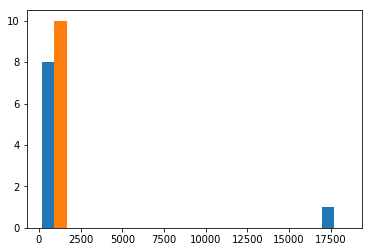

In [30]:
with tf.Session() as sess:
    filename =  'LibriSpeech/train-clean-100-all/3486-166424-0004.wav'
    raw_audio = tf.io.read_file(filename)
    audio, fs = decode_wav(raw_audio)
    print(np.shape(audio.eval()))
    print(fs.eval())
    
    # Get mfcc coefficients
    spectrogram = audio_ops.audio_spectrogram(
            audio, window_size=1024,stride=64)
    orig_inputs = audio_ops.mfcc(spectrogram, sample_rate=fs, dct_coefficient_count=numcep)
    
    audio_mfcc = orig_inputs.eval()
    print(audio_mfcc)
    print(np.shape(audio_mfcc))
    hist_audio = np.histogram(audio_mfcc, bins=range(9 + 1))
    plt.hist(hist_audio)
    plt.show()

[ 0.15  1.15  2.15  3.15  4.15  5.15  6.15  7.15  8.15  9.15 10.15 11.15
 12.15 13.15 14.15 15.15 16.15 17.15 18.15 19.15 20.15 21.15 22.15 23.15
 24.15 25.15]


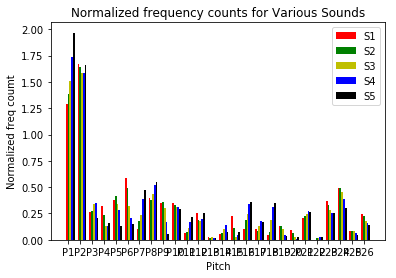

In [31]:
labels=[]
for i in np.arange(26):
    labels.append("P"+str(i+1))
    
fig, ax = plt.subplots()
ind = np.arange(len(labels))
width = 0.15
colors = ['r', 'g', 'y', 'b', 'black']
plots = []

for i in range(0, 5):
    Xs = np.asarray(np.abs(audio_mfcc[0][i])).reshape(-1)
    p = ax.bar(ind + i*width, Xs, width, color=colors[i])
    plots.append(p[0])

xticks = ind + width / (audio_mfcc.shape[0])
print(xticks)
ax.legend(tuple(plots), ('S1', 'S2', 'S3', 'S4', 'S5'))
ax.yaxis.set_units(inch)
ax.autoscale_view()
ax.set_xticks(xticks)
ax.set_xticklabels(labels)

ax.set_ylabel('Normalized freq coumt')
ax.set_xlabel('Pitch')
ax.set_title('Normalized frequency counts for Various Sounds')
plt.show()

In [32]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    filename =  'LibriSpeech/train-clean-100-all/3486-166424-0004.wav'
    raw_audio = tf.io.read_file(filename)
    audio, fs = decode_wav(raw_audio)
    
    wsize = 16384 #1024
    stride = 448 #64
    
    
    # Get mfcc coefficients
    spectrogram = audio_ops.audio_spectrogram(
            audio, window_size=wsize,stride=stride)
    numcep=26
    numcontext=9
    orig_inputs = audio_ops.mfcc(spectrogram, sample_rate=fs, dct_coefficient_count=numcep) 
    orig_inputs = orig_inputs[:,::2]
    
    audio_mfcc = orig_inputs.eval()
    print(audio_mfcc)
    print(np.shape(audio_mfcc))

    train_inputs = np.array([], np.float32)
    train_inputs.resize((audio_mfcc.shape[1], numcep + 2 * numcep * numcontext))

    # Prepare pre-fix post fix context
    empty_mfcc = np.array([])
    empty_mfcc.resize((numcep))
    empty_mfcc = tf.convert_to_tensor(empty_mfcc, dtype=tf.float32)
    empty_mfcc_ev = empty_mfcc.eval()
    
    # Prepare train_inputs with past and future contexts
    # This code always takes 9 time steps previous and 9 time steps in the future along with the current time step
    time_slices = range(train_inputs.shape[0])
    context_past_min = time_slices[0] + numcontext #starting min point for past content, has to be at least 9 ts
    context_future_max = time_slices[-1] - numcontext  #ending point  max for future content, size time slices - 9ts

    for time_slice in tqdm(time_slices):
        #print('time slice %d ' % (time_slice))
        # Reminder: array[start:stop:step]
        # slices from indice |start| up to |stop| (not included), every |step|

        # Add empty context data of the correct size to the start and end
        # of the MFCC feature matrix

        # Pick up to numcontext time slices in the past, and complete with empty
        # mfcc features
        need_empty_past = max(0, (context_past_min - time_slice))
        empty_source_past = np.asarray([empty_mfcc_ev for empty_slots in range(need_empty_past)])
        data_source_past = orig_inputs[0][max(0, time_slice - numcontext):time_slice]
        assert(len(empty_source_past) + data_source_past.eval().shape[0] == numcontext)

        # Pick up to numcontext time slices in the future, and complete with empty
        # mfcc features
        need_empty_future = max(0, (time_slice - context_future_max))
        empty_source_future = np.asarray([empty_mfcc_ev for empty_slots in range(need_empty_future)])
        data_source_future = orig_inputs[0][time_slice + 1:time_slice + numcontext + 1]
        assert(len(empty_source_future) + data_source_future.eval().shape[0] == numcontext)
        
        # pad if needed for the past or future, or else simply take past and future
        if need_empty_past:
            past = tf.concat([tf.cast(empty_source_past, tf.float32), tf.cast(data_source_past, tf.float32)], 0)
        else:
            past = data_source_past

        if need_empty_future:
            future = tf.concat([tf.cast(data_source_future, tf.float32), tf.cast(empty_source_future, tf.float32)], 0)
        else:
            future = data_source_future


        past = tf.reshape(past, [numcontext*numcep])
        now = orig_inputs[0][time_slice]
        future  = tf.reshape(future, [numcontext*numcep])

        train_inputs[time_slice] = np.concatenate((past.eval(), now.eval(), future.eval()))
        assert(train_inputs[time_slice].shape[0] == numcep + 2*numcep*numcontext)
        
    train_inputs = (train_inputs - np.mean(train_inputs)) / np.std(train_inputs)
    print('Train inputs shape %s ' % str(np.shape(train_inputs)))
    print('Train inputs '+str(train_inputs))


[[[ 4.30906334e+01 -2.03534174e+00  2.13124916e-01 ... -1.80211738e-01
   -1.85429707e-01 -2.71477193e-01]
  [ 4.31706581e+01 -2.00894237e+00  1.24617569e-01 ... -1.76925331e-01
   -1.90575659e-01 -2.57524341e-01]
  [ 4.31397552e+01 -1.99346173e+00  2.48030107e-02 ... -1.74366608e-01
   -2.01282144e-01 -2.28919283e-01]
  ...
  [ 3.75711555e+01  1.11948147e-01 -1.20602953e+00 ... -1.09063618e-01
   -1.47348404e-01 -4.01394591e-02]
  [ 3.72089195e+01  1.13353238e-01 -1.15313697e+00 ... -1.19969286e-01
   -1.65252820e-01 -3.10349297e-02]
  [ 3.66761971e+01  7.20925033e-02 -1.06190836e+00 ... -1.32965922e-01
   -1.79992720e-01 -2.88166851e-02]]]
(1, 165, 26)


/Users/mattmann/git/buildout.python/python-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Train inputs shape (165, 494) 
Train inputs [[-0.1549316  -0.1549316  -0.1549316  ... -0.16783054 -0.17190124
  -0.15780927]
 [-0.1549316  -0.1549316  -0.1549316  ... -0.16929814 -0.1677892
  -0.16038078]
 [-0.1549316  -0.1549316  -0.1549316  ... -0.17141952 -0.16438814
  -0.16207673]
 ...
 [ 4.868814   -0.3211337  -0.11208492 ... -0.1549316  -0.1549316
  -0.1549316 ]
 [ 4.8369946  -0.31495303 -0.11409124 ... -0.1549316  -0.1549316
  -0.1549316 ]
 [ 4.819872   -0.30001065 -0.13118725 ... -0.1549316  -0.1549316
  -0.1549316 ]]


In [33]:
filename =  'LibriSpeech/train-clean-100-all/3486-166424-0004.txt'
txt_file = normalize_txt_file(filename)

In [34]:
transcript =  text_to_char_array(txt_file)

In [35]:
transcript

array([ 1,  0,  8,  1, 18,  5,  0, 19,  1, 20,  0, 21, 16, 18,  9,  7,  8,
       20,  0,  9, 14,  0, 20,  8,  5,  0, 13,  9,  4,  4, 12,  5,  0, 15,
        6,  0, 20,  8,  5,  0,  1, 14,  3,  9,  5, 14, 20,  0, 18, 15,  1,
        4, 23,  1, 25,  0, 20,  8,  5,  0, 22,  1, 12, 12,  5, 25,  0,  9,
       20, 19,  5, 12,  6,  0, 12,  1, 25,  0, 19,  5, 18,  5, 14,  5, 12,
       25,  0, 21, 14,  4,  5, 18,  0, 20,  8,  5,  0,  1, 13,  2,  5, 18,
        9, 14,  7,  0, 12,  9,  7,  8, 20,  0, 19, 13,  9, 12,  9, 14,  7,
        0, 16,  5,  1,  3,  5,  6, 21, 12,  0,  5, 13, 16, 20,  9,  5,  4,
        0, 15,  6,  0,  8, 15, 18, 18, 15, 18])

In [36]:
np.shape(transcript)

(146,)

In [37]:
transcript_sparse = sparse_tuple_from(np.asarray([transcript]))

In [38]:
transcript_sparse

(array([[  0,   0],
        [  0,   1],
        [  0,   2],
        [  0,   3],
        [  0,   4],
        [  0,   5],
        [  0,   6],
        [  0,   7],
        [  0,   8],
        [  0,   9],
        [  0,  10],
        [  0,  11],
        [  0,  12],
        [  0,  13],
        [  0,  14],
        [  0,  15],
        [  0,  16],
        [  0,  17],
        [  0,  18],
        [  0,  19],
        [  0,  20],
        [  0,  21],
        [  0,  22],
        [  0,  23],
        [  0,  24],
        [  0,  25],
        [  0,  26],
        [  0,  27],
        [  0,  28],
        [  0,  29],
        [  0,  30],
        [  0,  31],
        [  0,  32],
        [  0,  33],
        [  0,  34],
        [  0,  35],
        [  0,  36],
        [  0,  37],
        [  0,  38],
        [  0,  39],
        [  0,  40],
        [  0,  41],
        [  0,  42],
        [  0,  43],
        [  0,  44],
        [  0,  45],
        [  0,  46],
        [  0,  47],
        [  0,  48],
        [  0,  49],


In [39]:
train, t_length = pad_sequences([train_inputs])

In [40]:
np.shape(train)

(1, 165, 494)

In [41]:
print(t_length)

[165]


In [42]:
print(train)

[[[-0.1549316  -0.1549316  -0.1549316  ... -0.16783054 -0.17190124
   -0.15780927]
  [-0.1549316  -0.1549316  -0.1549316  ... -0.16929814 -0.1677892
   -0.16038078]
  [-0.1549316  -0.1549316  -0.1549316  ... -0.17141952 -0.16438814
   -0.16207673]
  ...
  [ 4.868814   -0.3211337  -0.11208492 ... -0.1549316  -0.1549316
   -0.1549316 ]
  [ 4.8369946  -0.31495303 -0.11409124 ... -0.1549316  -0.1549316
   -0.1549316 ]
  [ 4.819872   -0.30001065 -0.13118725 ... -0.1549316  -0.1549316
   -0.1549316 ]]]


In [43]:
# e.g: log filter bank or MFCC features
# shape = [batch_size, max_stepsize, n_input + (2 * n_input * n_context)]
# the batch_size and max_stepsize can vary along each step
input_tensor  = tf.placeholder(tf.float32, [None, None, numcep + (2 * numcep * numcontext)], name='input')

# 1d array of size [batch_size]
seq_length = tf.placeholder(tf.int32, [None], name='seq_length')

# Use sparse_placeholder; will generate a SparseTensor, required by ctc_loss op.
targets = tf.sparse_placeholder(tf.int32, name='targets')
    
logits, summary_op = BiRNN_model(input_tensor, tf.to_int64(seq_length), numcep, numcontext)

        
total_loss = ctc_ops.ctc_loss(targets, logits, seq_length)
avg_loss = tf.reduce_mean(total_loss)
loss_summary = tf.summary.scalar("avg_loss", avg_loss)
cost_placeholder = tf.placeholder(dtype=tf.float32, shape=[])
train_cost_op = tf.summary.scalar(
                "train_avg_loss", cost_placeholder)

beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                   beta1=beta1,
                                   beta2=beta2,
                                   epsilon=epsilon)

train_op = optimizer.minimize(avg_loss)
num_epochs = 2

W0705 13:14:22.593894 4729562560 deprecation.py:323] From <ipython-input-43-4b2f3e65b422>:12: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0705 13:14:22.624637 4729562560 deprecation.py:506] From <ipython-input-15-5add8feef72b>:46: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0705 13:14:22.707309 4729562560 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0705 

In [44]:
BATCH_SIZE=10
train_size=25
train_audio_ds = tf.data.Dataset.from_tensor_slices(train_audio_wav[0:train_size-1])
combined_ds = train_audio_ds
combined_ds.batch(BATCH_SIZE)
combined_ds.shuffle(buffer_size=train_size)
combined_ds.prefetch(buffer_size=AUTOTUNE)

<DatasetV1Adapter shapes: (), types: tf.string>

In [45]:
train_cost = 0.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(0, num_epochs):
        iter = combined_ds.make_one_shot_iterator()
        batch_num = 0
        iter_op = iter.get_next()

        while True:
            try:
                train_batch = sess.run(iter_op)
                trans_batch = train_batch.decode("utf-8").split('.')[0] + ".txt"
                audio_data = process_audio(train_batch)
                train, t_length = pad_sequences([audio_data])
                trans = normalize_txt_file(trans_batch)
                trans_txt = text_to_char_array(trans)
                transcript_sparse = sparse_tuple_from(np.asarray([trans_txt]))

                feed = {input_tensor: train,
                        targets: transcript_sparse,
                        seq_length: t_length}
                batch_cost, _ = sess.run([avg_loss, train_op], feed_dict=feed)
                train_cost += batch_cost * BATCH_SIZE
                batch_num += 1
                print('Batch cost: %.2f' % (batch_cost))
            except tf.errors.OutOfRangeError:
                train_cost /= train_size
                print('Epoch %d | Train cost: %.2f' % (epoch, train_cost))
                break


W0705 13:14:25.870284 4729562560 deprecation.py:323] From <ipython-input-45-e206b424e58d>:6: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


Batch cost: 1418.85
Batch cost: 948.16
Batch cost: 1334.54
Batch cost: 396.95
Batch cost: 1592.06
Batch cost: 948.70
Batch cost: 2078.00
Batch cost: 1555.41
Batch cost: 1458.77
Batch cost: 1193.64
Batch cost: 793.83
Batch cost: 743.53
Batch cost: 1124.67
Batch cost: 922.67
Batch cost: 317.59
Batch cost: 667.24
Batch cost: 867.80
Batch cost: 882.51
Batch cost: 901.32
Batch cost: 796.56
Batch cost: 870.77
Batch cost: 1268.65
Batch cost: 1025.62
Batch cost: 850.91
Epoch 0 | Train cost: 9983.50
Batch cost: 681.11
Batch cost: 221.20
Batch cost: 518.57
Batch cost: 240.81
Batch cost: 857.12
Batch cost: 212.56
Batch cost: 842.22
Batch cost: 868.37
Batch cost: 808.33
Batch cost: 710.50
Batch cost: 586.45
Batch cost: 617.67
Batch cost: 800.37
Batch cost: 689.50
Batch cost: 272.63
Batch cost: 528.65
Batch cost: 752.01
Batch cost: 787.21
Batch cost: 798.88
Batch cost: 654.88
Batch cost: 757.17
Batch cost: 998.92
Batch cost: 771.30
Batch cost: 655.99
Epoch 1 | Train cost: 6652.31
